In [5]:
import pandas as pd
import numpy as np
import optuna

df = pd.read_csv("../180 days/predictions/actual.csv")
df["date"] = pd.to_datetime(df["date"]).dt.normalize()
df = df.sort_values("date")

df_180 = df.tail(180)[["date", "actual"]].copy()

print(df_180.head(2))
print(df_180.tail(2))

        date  actual
0 2024-02-08      35
1 2024-02-09      31
         date  actual
88 2024-05-06      33
89 2024-05-07      33


In [6]:
df_180["date"] = pd.to_datetime(df_180["date"]).dt.normalize()

arima  = pd.read_csv("../180 days/predictions/arima_predictions_180.csv")
sarima = pd.read_csv("../180 days/predictions/sarima_predictions_180.csv")
rf     = pd.read_csv("../180 days/predictions/rf_predictions_180.csv")
gb     = pd.read_csv("../180 days/predictions/gb_predictions_180.csv")

In [7]:
# Normalize dates in all prediction tables
for d in [arima, sarima, rf, gb]:
    d["date"] = pd.to_datetime(d["date"]).dt.normalize()

In [8]:
arima = arima[["date", "arima_pred"]].rename(columns={"arima_pred": "pred_arima"})

In [9]:
sarima_pred_col = None
for c in sarima.columns:
    if c.lower() in ["sarima", "sarima_pred"]:
        sarima_pred_col = c
        break
if sarima_pred_col is None:
    raise ValueError(f"Can't find SARIMA prediction column in: {sarima.columns.tolist()}")

sarima = sarima[["date", sarima_pred_col]].rename(columns={sarima_pred_col: "pred_sarima"})

In [10]:
rf = rf[["date", "rf_1", "rf_2", "rf_3", "rf_4", "rf_5"]].rename(columns={
    "rf_1":"pred_rf_1", "rf_2":"pred_rf_2", "rf_3":"pred_rf_3", "rf_4":"pred_rf_4", "rf_5":"pred_rf_5"
})

In [11]:
gb = gb[["date", "gb_1", "gb_2", "gb_3", "gb_4", "gb_5"]].rename(columns={
    "gb_1":"pred_gb_1", "gb_2":"pred_gb_2", "gb_3":"pred_gb_3", "gb_4":"pred_gb_4", "gb_5":"pred_gb_5"
})

In [12]:
df_180 = df_180.drop(columns=[c for c in df_180.columns if c.startswith("pred_")], errors="ignore")

df_180 = df_180.merge(arima,  on="date", how="left", validate="one_to_one")
df_180 = df_180.merge(sarima, on="date", how="left", validate="one_to_one")
df_180 = df_180.merge(rf,     on="date", how="left", validate="one_to_one")
df_180 = df_180.merge(gb,     on="date", how="left", validate="one_to_one")

In [14]:
pred_cols = ["pred_arima", "pred_sarima",
             "pred_rf_1","pred_rf_2","pred_rf_3","pred_rf_4","pred_rf_5",
             "pred_gb_1","pred_gb_2","pred_gb_3","pred_gb_4","pred_gb_5"]

missing = df_180[pred_cols].isna().sum()
print("Missing counts (only show >0):\n", missing[missing > 0])
assert missing.sum() == 0, "Some predictions didn't match dates!"

print("✅ Merge done. df_180 columns now include predictions.")
print(df_180.columns.tolist())

Missing counts (only show >0):
 Series([], dtype: int64)
✅ Merge done. df_180 columns now include predictions.
['date', 'actual', 'pred_arima', 'pred_sarima', 'pred_rf_1', 'pred_rf_2', 'pred_rf_3', 'pred_rf_4', 'pred_rf_5', 'pred_gb_1', 'pred_gb_2', 'pred_gb_3', 'pred_gb_4', 'pred_gb_5']


In [15]:
rf_cols = ["pred_rf_1","pred_rf_2","pred_rf_3","pred_rf_4","pred_rf_5"]
gb_cols = ["pred_gb_1","pred_gb_2","pred_gb_3","pred_gb_4","pred_gb_5"]

df_180["rf_mean"] = df_180[rf_cols].mean(axis=1)
df_180["rf_std"]  = df_180[rf_cols].std(axis=1)

df_180["gb_mean"] = df_180[gb_cols].mean(axis=1)
df_180["gb_std"]  = df_180[gb_cols].std(axis=1)

X_meta = df_180[["pred_arima", "pred_sarima", "rf_mean", "rf_std", "gb_mean", "gb_std"]]
y_meta = df_180["actual"].to_numpy()

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

stacker = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0, random_state=42))
])

stacker.fit(X_meta, y_meta)
df_180["stack"] = stacker.predict(X_meta)

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("\nRMSE comparisons on last 180 days:")
print("ARIMA   :", rmse(y_meta, df_180["pred_arima"]))
print("SARIMA  :", rmse(y_meta, df_180["pred_sarima"]))
print("RF_mean :", rmse(y_meta, df_180["rf_mean"]))
print("GB_mean :", rmse(y_meta, df_180["gb_mean"]))
print("STACK   :", rmse(y_meta, df_180["stack"]))

print("\nMAE STACK:", mean_absolute_error(y_meta, df_180["stack"]))


RMSE comparisons on last 180 days:
ARIMA   : 6.174079735002035
SARIMA  : 6.182725392481693
RF_mean : 6.300221545825793
GB_mean : 6.155049944223407
STACK   : 6.056441485933154

MAE STACK: 4.662213867956144


In [18]:
y_true = y_meta
y_pred = df_180["stack"].to_numpy()

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    eps = 1e-8  # avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

RMSE = rmse(y_true, y_pred)
MAE  = mean_absolute_error(y_true, y_pred)
MAPE = mape(y_true, y_pred)
ACC  = 100 - MAPE  # "accuracy" in your definition

print(f"STACK RMSE      : {RMSE:.4f}")
print(f"STACK MAE       : {MAE:.4f}")
print(f"STACK MAPE (%)  : {MAPE:.4f}")
print(f"STACK Accuracy% : {ACC:.4f}")

STACK RMSE      : 6.0564
STACK MAE       : 4.6622
STACK MAPE (%)  : 16.6479
STACK Accuracy% : 83.3521


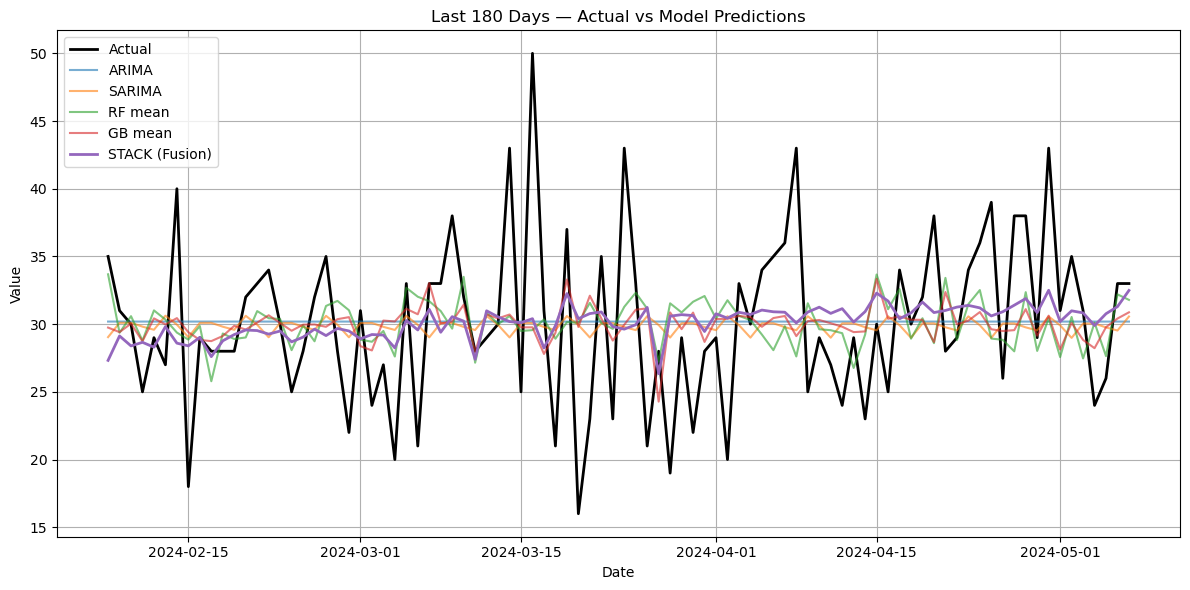

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(df_180["date"], y_meta, label="Actual", linewidth=2, color="black")
plt.plot(df_180["date"], df_180["pred_arima"], label="ARIMA", alpha=0.6)
plt.plot(df_180["date"], df_180["pred_sarima"], label="SARIMA", alpha=0.6)
plt.plot(df_180["date"], df_180["rf_mean"], label="RF mean", alpha=0.6)
plt.plot(df_180["date"], df_180["gb_mean"], label="GB mean", alpha=0.6)
plt.plot(df_180["date"], df_180["stack"], label="STACK (Fusion)", linewidth=2)

plt.title("Last 180 Days — Actual vs Model Predictions")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()